***Problem Understanding (VERY IMPORTANT)***
- *Target: `charges` (continuous → regression)*
- *Real-world nature:*
- * *Strong non-linear relationships*
- * *Heavy right-skew (outliers)*
- * *Mixed numerical + categorical features*

*Business expectation:*
- * *Interpretability matters (insurance domain)*
- * *Overfitting is dangerous*

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
df = pd.read_csv('12insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [16]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [17]:
X = df.drop("charges", axis=1)
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [18]:
y = df["charges"]
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])


In [21]:
#baseline model:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

baseline_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

baseline_pipe.fit(X_train, y_train)

preds = baseline_pipe.predict(X_test)

print("R2:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))

R2: 0.7835929767120722
MAE: 4181.194473753652


In [ ]:
#Tree-Based Model: Random Forest (Non-linear, Robust)
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)

rf_preds = rf_pipe.predict(X_test)

print("R2:", r2_score(y_test, rf_preds))
print("MAE:", mean_absolute_error(y_test, rf_preds))

R2: 0.8644197237303527
MAE: 2553.60906639433


***Why RF works better:***
- *Handles non-linearity*
- *Robust to outliers*
- *Captures interactions automatically*

In [23]:
#Cross-Validation:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf_pipe,
    X, y,
    cv=5,
    scoring="r2"
)

scores.mean()


np.float64(0.8377326670526049)

In [25]:
#Feature Importance (Insurance Needs Explainability):
model = rf_pipe.named_steps["model"]
features = rf_pipe.named_steps["preprocessor"].get_feature_names_out()

fi = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

fi

,Feature,Importance
4,cat__smoker_yes,0.610025
1,num__bmi,0.214874
0,num__age,0.134250
2,num__children,0.019428
3,cat__sex_male,0.006330
5,cat__region_northwest,0.005669
6,cat__region_southeast,0.005268
7,cat__region_southwest,0.004158


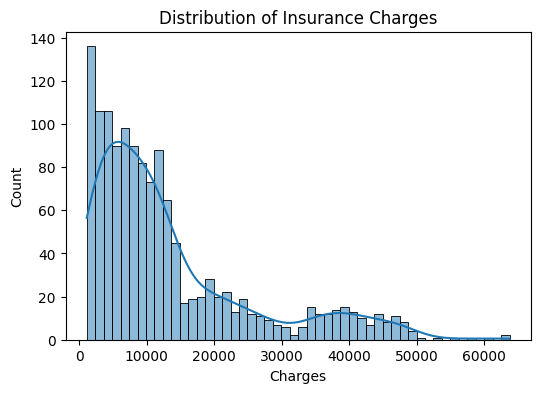

In [26]:
plt.figure(figsize=(6,4))
sns.histplot(y, bins=50, kde=True)
plt.title("Distribution of Insurance Charges")
plt.xlabel("Charges")
plt.show()

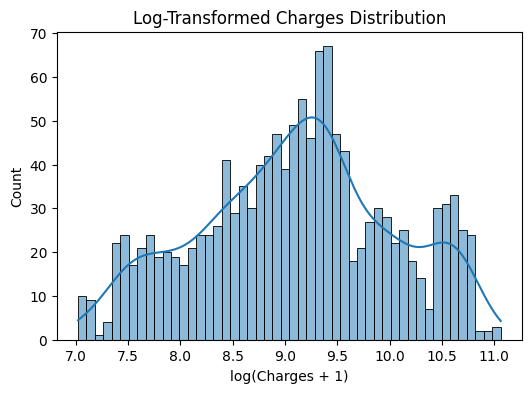

In [27]:
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(y), bins=50, kde=True)
plt.title("Log-Transformed Charges Distribution")
plt.xlabel("log(Charges + 1)")
plt.show()


> *Log transformation stabilizes variance and makes regression assumptions more realistic.*

***Feature vs Target Relationship (EDA That Matters):***

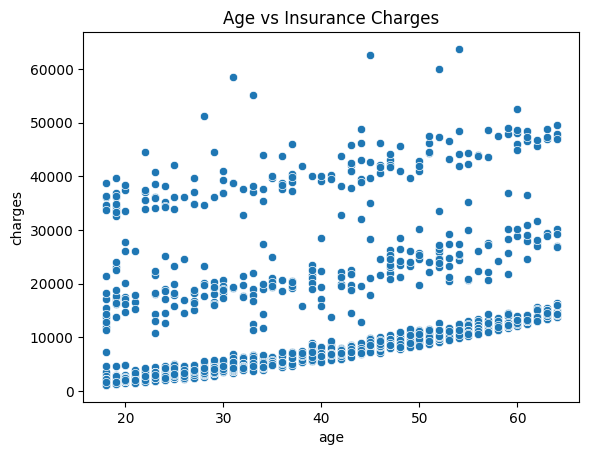

In [28]:
sns.scatterplot(x=df["age"], y=df["charges"])
plt.title("Age vs Insurance Charges")
plt.show()

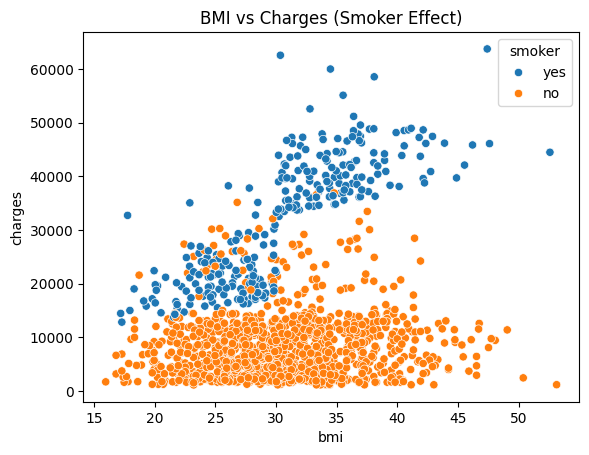

In [29]:
sns.scatterplot(
    x=df["bmi"],
    y=df["charges"],
    hue=df["smoker"]
)
plt.title("BMI vs Charges (Smoker Effect)")
plt.show()


>*Smoking introduces a sharp non-linear jump in medical costs, especially at higher BMI.*

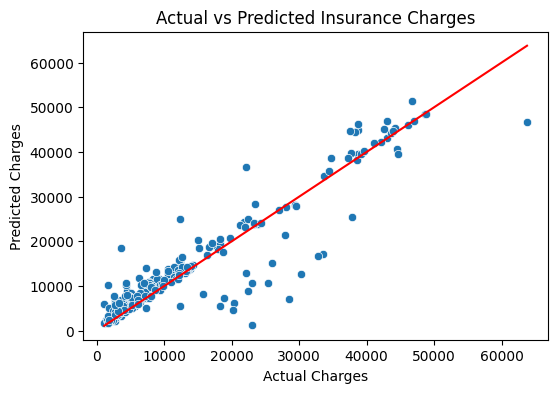

In [31]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=rf_preds)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Insurance Charges")
plt.show()


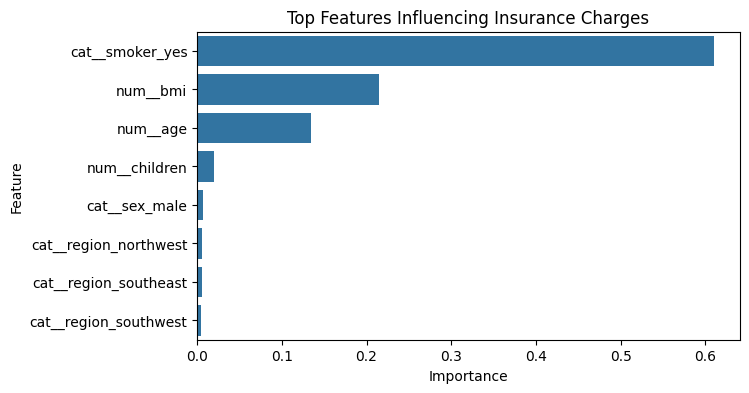

In [32]:
top_fi = fi.head(10)

plt.figure(figsize=(7,4))
sns.barplot(
    x=top_fi["Importance"],
    y=top_fi["Feature"]
)
plt.title("Top Features Influencing Insurance Charges")
plt.show()


c:\Users\arrma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\inspection\_partial_dependence.py:721: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


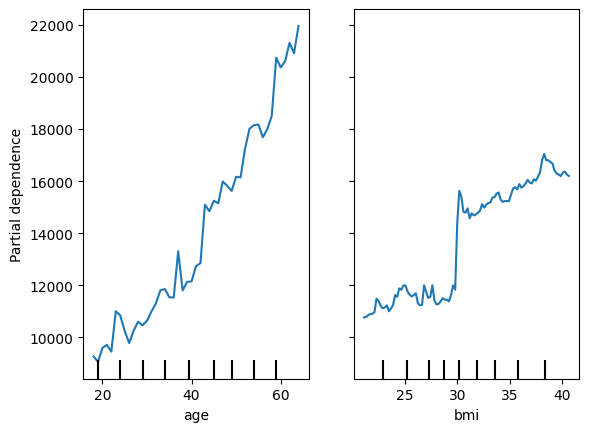

In [33]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    rf_pipe,
    X_train,
    ["age", "bmi"]
)
plt.show()


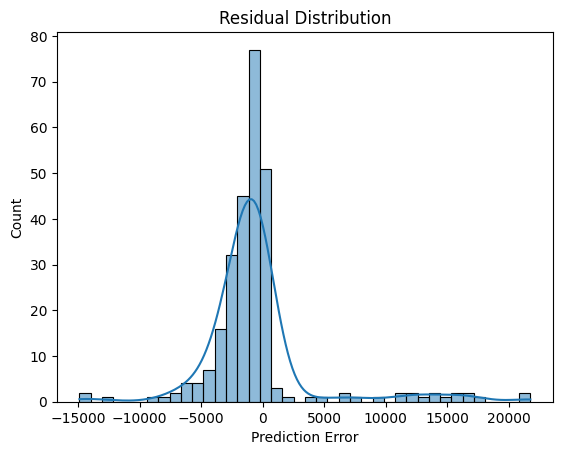

In [34]:
residuals = y_test - rf_preds

sns.histplot(residuals, bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error")
plt.show()